In [18]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 207.98 # Lead-208
Z = 82  # Number of protons in the ion (Lead)
Ne = 3 # Number of remaining electrons (Lithium-like)
q0=Z-Ne
m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
clight = 299792458.0 # m/s

m_ion = A*m_u + Ne*m_e # eV/c^2
equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

p0c = equiv_proton_momentum*(q0) # eV/c
gamma = np.sqrt( 1 + (p0c/m_ion)**2 ) # ion relativistic factor
beta = np.sqrt(1-1/(gamma*gamma)) # ion beta


In [19]:
q0

79

In [20]:
#%%
##################
# Build TrackJob #
##################

# fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

# with open(fname_sequence, 'r') as fid:
#      input_data = json.load(fid)
# SPS_line = xt.Line.from_dict(input_data['line'])

#Build a reference particle
#particle_ref = xp.Particles(mass0=m_ion, q0=q0, p0c=p0c)




with open("SPS_sequence/SPS_2021_Pb_nominal.json") as fid:
    dd=json.load(fid)
SPS_line = xt.Line.from_dict(dd)
particle_ref=SPS_line.particle_ref
# SPS_line.particle_ref=particle_ref

num_particles = int(1e4)

twiss = SPS_line.twiss(symplectify=True)

twiss_dict=dict(twiss)

circumference=twiss['s'][-1]

nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 0.063 # m

emittance=nemitt*beta*gamma

particles = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        #total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        #R_matrix=r_matrix,
        particle_ref=particle_ref,
        line=SPS_line
        #,steps_r_matrix=steps_r_matrix
        )
particles0=particles.copy()

e0=particle_ref.energy
de_e=(particles0.energy-e0)/e0

print('rms energy:',np.std(de_e*1e4))
print('rms delta:',np.std(particles0.delta*1e4))


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.2341160338197291m.
... distance to target bunch length: -6.1447e-02
... distance to target bunch length: 1.6465e-01
... distance to target bunch length: 7.5601e-02
... distance to target bunch length: -4.4822e-03
... distance to target bunch length: -2.2862e-05
... distance to target bunch length: -1.0664e-08
... distance to target bunch length: 3.1660e-07
--> Bunch length: 0.06299998933560952
--> Emittance: 0.0070512249698623745
rms energy: 1.5269859051730896
rms delta: 1.5560601367409255


In [21]:
#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101

In [22]:
betax=twiss.betx
betay=twiss.bety
alphax=twiss.alfx
alphay=twiss.alfy

In [23]:
closest_index = np.abs(betax - beta_x).argmin()
closest_number = betax[closest_index]

In [24]:
alphax[closest_index]

-1.545614189980809

In [25]:
closest_index

16675

In [26]:
print('rms x:',np.std(particles0.x*1e3))
# print('rms px:',np.std(particles0.px*1e3))
print('rms y:',np.std(particles0.y*1e3))
# print('rms py:',np.std(particles0.py*1e3))

rms x: 4.652093738158946
rms y: 2.0753236525449927


In [27]:
particles0.q0

82.0

discard rest of line

In [28]:
# SPS_short=SPS_line[:closest_index]

# print(len(SPS_short))

# SPS_IP=xt.Line(SPS_short)
# SPS_IP.build_tracker()

# SPS_IP.track(particles)

In [29]:
std_delta0=np.std(particles0.delta*1e4)
std_delta=np.std(particles.delta*1e4)

std_zeta0=np.std(particles0.zeta*1e2)
std_zeta=np.std(particles.zeta*1e2)



std_x0=np.std(particles0.x*1e4)
std_x=np.std(particles.x*1e4)

In [30]:
std_delta0

LinkedArrayCpu(1.55606014)

gamma factory

In [31]:
##################
# Laser Cooler #
##################
sigma_dp=np.std(particles0.delta)
#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
# theta_l = 0
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 230.823 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
lambda_l = lambda_l*(1+0*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy=5e-3

GF_IP = xt.PulsedLaser(
                laser_x=0,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = 76.6e-12, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 20
int_time_s = 0.1
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

num_turns = int(2e0)
save_interval = num_turns/100
save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=num_particles)


SPS_line.discard_tracker()
IP_index=16675   
# SPS_line.insert_element('monitor', element=monitor, index=IP_index)
# SPS_line.insert_element('GF_IP', element=GF_IP, index=IP_index)
# SPS_line.append_element(monitor,'monitor')
SPS_line.append_element(GF_IP,'GF_IP')
SPS_line.build_tracker()

#(SPS_line.element_names[closest_index+1])

Laser pulse duration sigma_t = 3.53 ps
Laser wavelength = 1033.33 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [32]:
SPS_line.track(particles)

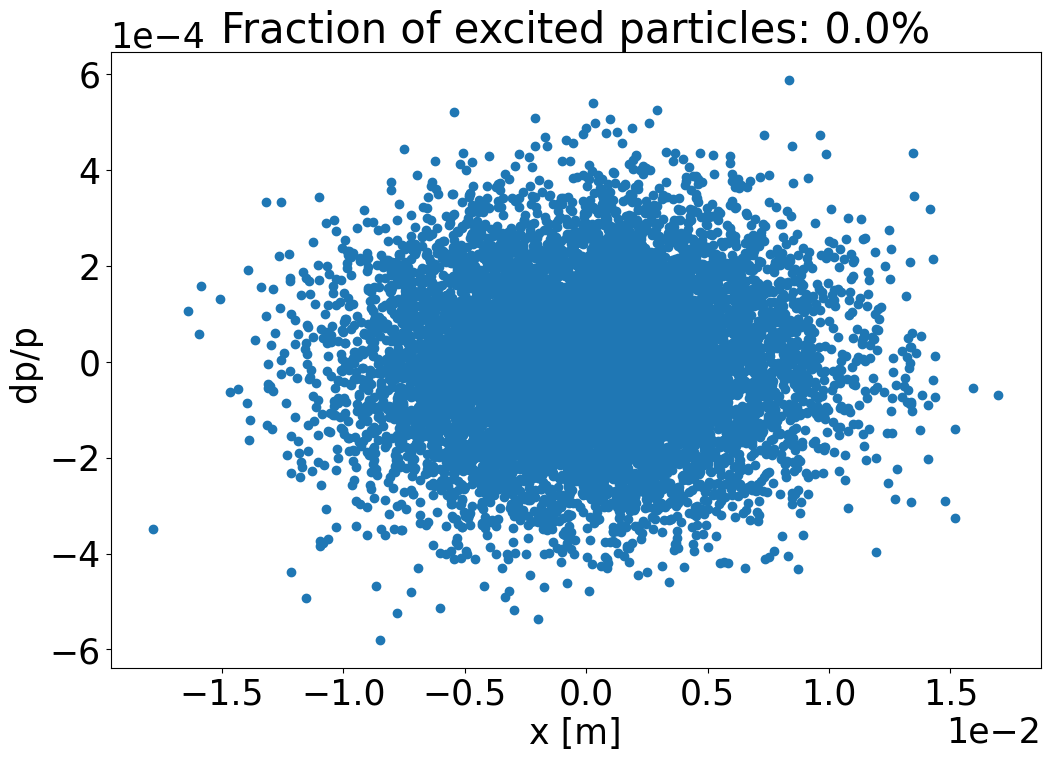

In [33]:
excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.delta)
plt.scatter(particles.x[excited],particles.delta[excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

In [34]:
excited

array([False, False, False, ..., False, False, False])